In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.preprocessing.sequence import TimeseriesGenerator

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# BTC-USD

In [120]:
df = pd.read_csv('/content/drive/MyDrive/BA/Dataset/BTC-USD.csv',usecols=['Date','Close'],index_col='Date',parse_dates=True)

In [121]:
df.head()

,Close
Date,
2017-01-01,998.325012
2017-01-02,1021.750000
2017-01-03,1043.839966
2017-01-04,1154.729980
2017-01-05,1013.380005


<Axes: xlabel='Date'>

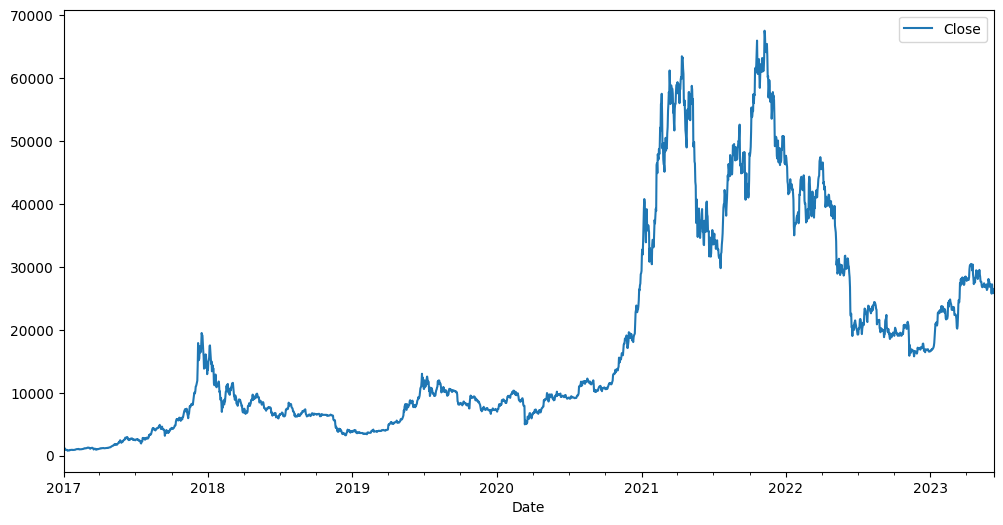

In [122]:
df.plot(figsize=(12,6))

In [123]:
df1 = df.reset_index()['Close']

In [124]:
len(df1)

2352

## 7:2:1

In [125]:
scaler = MinMaxScaler(feature_range=(0,1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1,1))

In [126]:
train_size = int(0.7 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size + test_size]
val_data = df1[train_size + test_size:]

In [127]:
import numpy
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [128]:
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [129]:
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1], 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1], 1)

In [130]:
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(100,1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [131]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 100)               40800     
                                                                 
 dense_6 (Dense)             (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [132]:
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
25/25 [==============================] - 6s 153ms/step - loss: 0.0220 - val_loss: 0.0099
Epoch 2/100
25/25 [==============================] - 5s 220ms/step - loss: 0.0014 - val_loss: 0.0019
Epoch 3/100
25/25 [==============================] - 4s 144ms/step - loss: 9.9704e-04 - val_loss: 0.0023
Epoch 4/100
25/25 [==============================] - 4s 141ms/step - loss: 7.2075e-04 - val_loss: 0.0014
Epoch 5/100
25/25 [==============================] - 4s 155ms/step - loss: 6.1220e-04 - val_loss: 0.0017
Epoch 6/100
25/25 [==============================] - 5s 209ms/step - loss: 5.7530e-04 - val_loss: 0.0012
Epoch 7/100
25/25 [==============================] - 3s 140ms/step - loss: 5.8133e-04 - val_loss: 0.0012
Epoch 8/100
25/25 [==============================] - 3s 139ms/step - loss: 5.8648e-04 - val_loss: 0.0011
Epoch 9/100
25/25 [==============================] - 5s 189ms/step - loss: 5.2787e-04 - val_loss: 0.0013
Epoch 10/100
25/25 [==============================] - 4s 176ms/

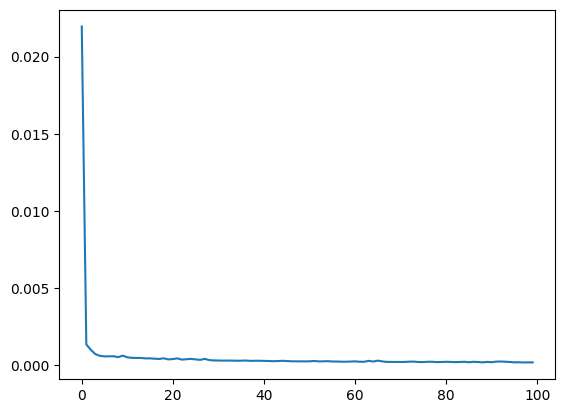

In [133]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [134]:
train_predict = model.predict(X_train)
y_pred = model.predict(X_test)
y_pred_val = model.predict(X_val)

5/5 [==============================] - 0s 24ms/step


In [135]:
train_predict = scaler.inverse_transform(train_predict)
y_pred = scaler.inverse_transform(y_pred)
y_pred_val = scaler.inverse_transform(y_pred_val)

In [136]:
y_pred.shape

(369, 1)

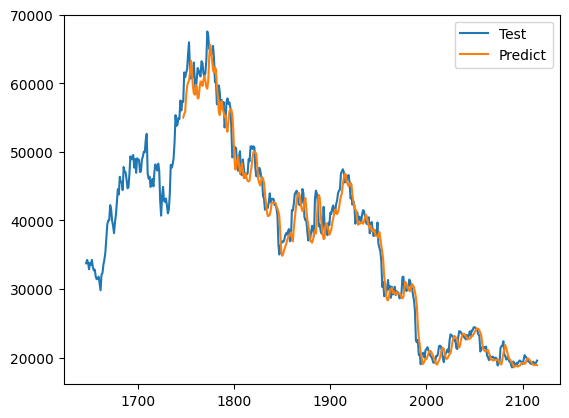

In [137]:
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))

test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))

plt.legend(['Test','Predict'])
plt.show()

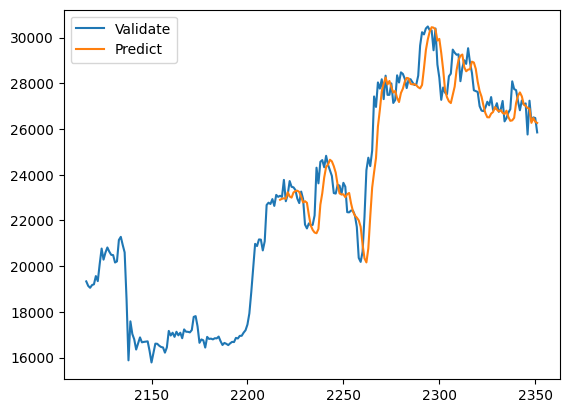

In [138]:
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))

val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)

plt.legend(['Validate','Predict'])
plt.show()

In [139]:
valid_mae = np.mean(np.abs(y_pred_val - yval))
test_mae = np.mean(np.abs(y_pred - ytest))

print('Validation MAE:', valid_mae)
print('Testing MAE:', test_mae)
print('-------------------')

valid_mse = np.mean((y_pred_val - yval)**2)
test_mse = np.mean((y_pred - ytest)**2)

print('Validation MSE:', valid_mse)
print('Testing MSE:', test_mse)
print('-------------------')

valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))

print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)
print('-------------------')

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

valid_mape = mean_absolute_percentage_error(y_pred_val, yval)
test_mape = mean_absolute_percentage_error(y_pred, ytest)
print('Validation MAPE:', valid_mape)
print('Testing MAPE:', test_mape)

Validation MAE: 25914.24247681058
Testing MAE: 35927.66962154018
-------------------
Validation MSE: 678489132.14188
Testing MSE: 1469966150.6454382
-------------------
Validation RMSE: 26047.823942546143
Testing RMSE: 38340.13759293827
-------------------
Validation MAPE: 99.99851867029285
Testing MAPE: 99.9982755820306


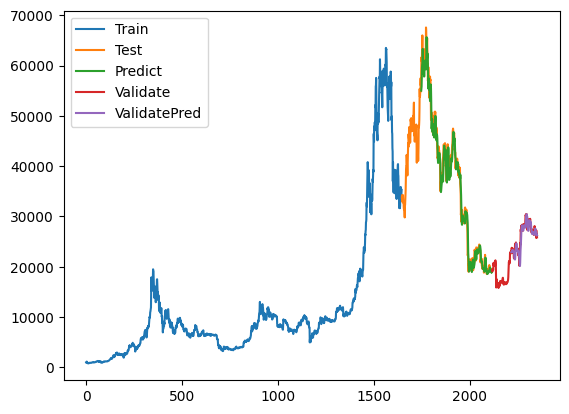

In [140]:
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))

val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)

plt.legend(['Train','Test','Predict','Validate','ValidatePred'])
plt.show()

## 5:3:2

In [141]:
train_size1 = int(0.5 * len(df1))
test_size1 = int(0.3 * len(df1))
val_size1 = len(df1) - train_size1 - test_size1

train_data1 = df1[:train_size1]
test_data1 = df1[train_size1:train_size1 + test_size1]
val_data1 = df1[train_size1 + test_size1:]

In [142]:
time_step = 100
X_train1, y_train1 = create_dataset(train_data1, time_step)
X_val1, yval1 = create_dataset(val_data1, time_step)
X_test1, ytest1 = create_dataset(test_data1, time_step)

In [143]:
X_train1 = X_train1.reshape(X_train1.shape[0],X_train1.shape[1], 1)
X_test1 = X_test1.reshape(X_test1.shape[0],X_test1.shape[1], 1)
X_val1 = X_val1.reshape(X_val1.shape[0],X_val1.shape[1], 1)

In [144]:
# define model
model1 = Sequential()
model1.add(LSTM(100, activation='relu', input_shape=(100,1)))
model1.add(Dense(1))
model1.compile(optimizer='adam', loss='mean_squared_error')

In [145]:
model1.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_7 (LSTM)               (None, 100)               40800     
                                                                 
 dense_7 (Dense)             (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [146]:
model1.fit(X_train1,y_train1,validation_data=(X_test1,ytest1),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
17/17 [==============================] - 7s 314ms/step - loss: 0.0044 - val_loss: 0.0836
Epoch 2/100
17/17 [==============================] - 3s 165ms/step - loss: 0.0011 - val_loss: 0.0719
Epoch 3/100
17/17 [==============================] - 3s 161ms/step - loss: 5.9414e-04 - val_loss: 0.0093
Epoch 4/100
17/17 [==============================] - 3s 172ms/step - loss: 2.4975e-04 - val_loss: 113141300068352.0000
Epoch 5/100
17/17 [==============================] - 4s 234ms/step - loss: 1.8228e-04 - val_loss: 0.0767
Epoch 6/100
17/17 [==============================] - 4s 219ms/step - loss: 1.6344e-04 - val_loss: 0.0128
Epoch 7/100
17/17 [==============================] - 3s 172ms/step - loss: 1.4917e-04 - val_loss: 0.0067
Epoch 8/100
17/17 [==============================] - 3s 157ms/step - loss: 1.3764e-04 - val_loss: 0.0051
Epoch 9/100
17/17 [==============================] - 3s 161ms/step - loss: 1.3081e-04 - val_loss: 0.0027
Epoch 10/100
17/17 [=============================

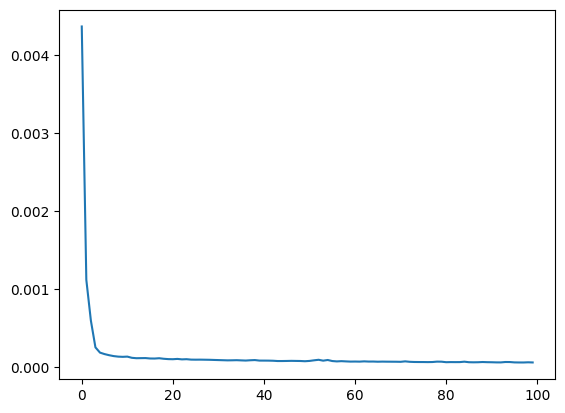

In [147]:
loss_per_epoch = model1.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [148]:
train_predict1 = model.predict(X_train1)
y_pred1 = model.predict(X_test1)
y_pred_val1 = model.predict(X_val1)

12/12 [==============================] - 0s 31ms/step


In [149]:
train_predict1 = scaler.inverse_transform(train_predict1)
y_pred1 = scaler.inverse_transform(y_pred1)
y_pred_val1 = scaler.inverse_transform(y_pred_val1)

In [150]:
test_data.shape

(470, 1)

In [151]:
y_pred1.shape

(604, 1)

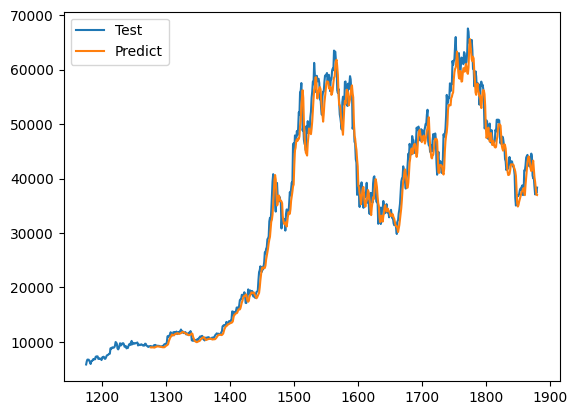

In [152]:
test_data_index1 = pd.RangeIndex(start=train_size1, stop=train_size1+test_size1, step=1)
plt.plot(test_data_index1,scaler.inverse_transform(test_data1))

test_data_index1 = pd.RangeIndex(start=train_size1+101, stop=train_size1+test_size1, step=1)
plt.plot(test_data_index1,(y_pred1))

plt.legend(['Test','Predict'])
plt.show()

In [153]:
val_data1.shape

(471, 1)

In [154]:
y_pred_val1.shape

(370, 1)

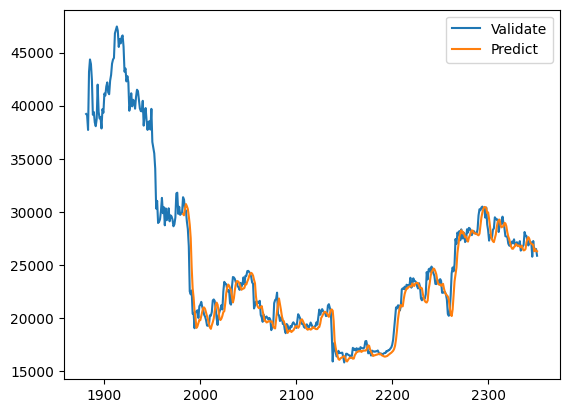

In [155]:
val_data_index1 = pd.RangeIndex(start=train_size1+test_size1, stop=train_size1+test_size1+val_size1, step=1)
plt.plot(val_data_index1,scaler.inverse_transform(val_data1))

val_data_index1 = pd.RangeIndex(start=train_size1+test_size1+101, stop=train_size1+test_size1+val_size1, step=1)
plt.plot(val_data_index1,y_pred_val1)

plt.legend(['Validate','Predict'])
plt.show()

In [156]:
valid_mae1 = np.mean(np.abs(y_pred_val1 - yval1))
test_mae1 = np.mean(np.abs(y_pred1 - ytest1))

print('Validation MAE:', valid_mae1)
print('Testing MAE:', test_mae1)
print('-------------------')

valid_mse1 = np.mean((y_pred_val1 - yval1)**2)
test_mse1 = np.mean((y_pred1 - ytest1)**2)

print('Validation MSE:', valid_mse1)
print('Testing MSE:', test_mse1)
print('-------------------')

valid_rmse1 = np.sqrt(np.mean((y_pred_val1 - yval1)**2))
test_rmse1 = np.sqrt(np.mean((y_pred1 - ytest1)**2))

print('Validation RMSE:', valid_rmse1)
print('Testing RMSE:', test_rmse1)
print('-------------------')

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

valid_mape1 = mean_absolute_percentage_error(y_pred_val1, yval1)
test_mape1 = mean_absolute_percentage_error(y_pred1, ytest1)
print('Validation MAPE:', valid_mape1)
print('Testing MAPE:', test_mape1)

Validation MAE: 22083.449065802095
Testing MAE: 35749.705936276354
-------------------
Validation MSE: 504212574.092197
Testing MSE: 1561059947.4278178
-------------------
Validation RMSE: 22454.678222860308
Testing RMSE: 39510.251168877905
-------------------
Validation MAPE: 99.99849214273372
Testing MAPE: 99.99781499576143


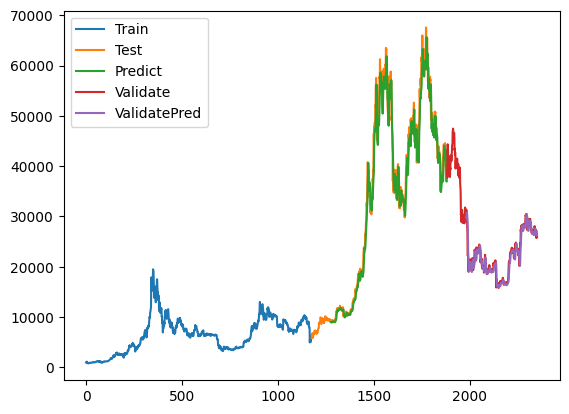

In [157]:
train_data_index1 = pd.RangeIndex(start=0, stop=train_size1, step=1)
plt.plot(scaler.inverse_transform(train_data1))

test_data_index1 = pd.RangeIndex(start=train_size1, stop=train_size1+test_size1, step=1)
plt.plot(test_data_index1,scaler.inverse_transform(test_data1))
test_data_index1 = pd.RangeIndex(start=train_size1+101, stop=train_size1+test_size1, step=1)
plt.plot(test_data_index1,(y_pred1))

val_data_index1 = pd.RangeIndex(start=train_size1+test_size1, stop=train_size1+test_size1+val_size1, step=1)
plt.plot(val_data_index1,scaler.inverse_transform(val_data1))
val_data_index1 = pd.RangeIndex(start=train_size1+test_size1+101, stop=train_size1+test_size1+val_size1, step=1)
plt.plot(val_data_index1,y_pred_val1)

plt.legend(['Train','Test','Predict','Validate','ValidatePred'])
plt.show()

# DOGE-USD

In [158]:
df = pd.read_csv('/content/drive/MyDrive/BA/Dataset/DOGE-USD.csv',usecols=['Date','Close'],index_col='Date',parse_dates=True)

In [159]:
df.head()

,Close
Date,
2017-11-09,0.001415
2017-11-10,0.001163
2017-11-11,0.001201
2017-11-12,0.001038
2017-11-13,0.001211


<Axes: xlabel='Date'>

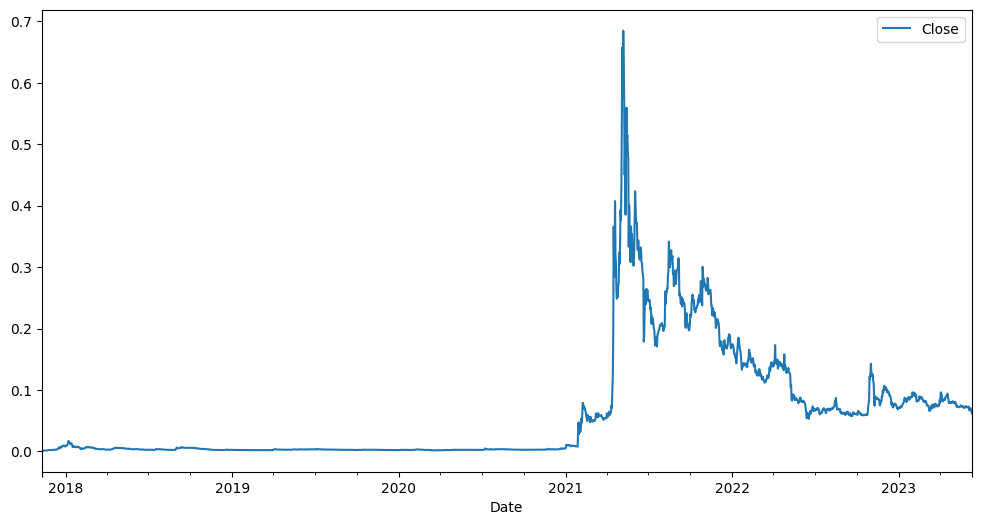

In [160]:
df.plot(figsize=(12,6))

In [161]:
df1 = df.reset_index()['Close']

In [162]:
len(df1)

2040

## 7:2:1

In [163]:
scaler = MinMaxScaler(feature_range=(0,1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1,1))

In [164]:
train_size = int(0.7 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size + test_size]
val_data = df1[train_size + test_size:]

In [165]:
import numpy
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [166]:
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [167]:
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1], 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1], 1)

In [168]:
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(100,1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [169]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 100)               40800     
                                                                 
 dense_8 (Dense)             (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [170]:
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
21/21 [==============================] - 6s 206ms/step - loss: 0.0089 - val_loss: 0.0022
Epoch 2/100
21/21 [==============================] - 4s 200ms/step - loss: 0.0020 - val_loss: 4.2839e-04
Epoch 3/100
21/21 [==============================] - 3s 146ms/step - loss: 0.0014 - val_loss: 3.3443e-04
Epoch 4/100
21/21 [==============================] - 3s 146ms/step - loss: 0.0013 - val_loss: 2.8678e-04
Epoch 5/100
21/21 [==============================] - 4s 182ms/step - loss: 0.0011 - val_loss: 5.0404e-04
Epoch 6/100
21/21 [==============================] - 4s 210ms/step - loss: 0.0011 - val_loss: 6.2194e-04
Epoch 7/100
21/21 [==============================] - 3s 148ms/step - loss: 9.6709e-04 - val_loss: 6.9421e-04
Epoch 8/100
21/21 [==============================] - 3s 144ms/step - loss: 9.2874e-04 - val_loss: 8.0988e-04
Epoch 9/100
21/21 [==============================] - 3s 151ms/step - loss: 9.5617e-04 - val_loss: 3.9927e-04
Epoch 10/100
21/21 [===========================

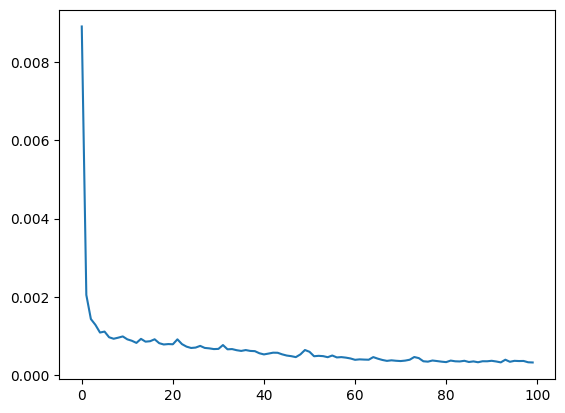

In [171]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [172]:
train_predict = model.predict(X_train)
y_pred = model.predict(X_test)
y_pred_val = model.predict(X_val)

4/4 [==============================] - 0s 24ms/step


In [173]:
train_predict = scaler.inverse_transform(train_predict)
y_pred = scaler.inverse_transform(y_pred)
y_pred_val = scaler.inverse_transform(y_pred_val)

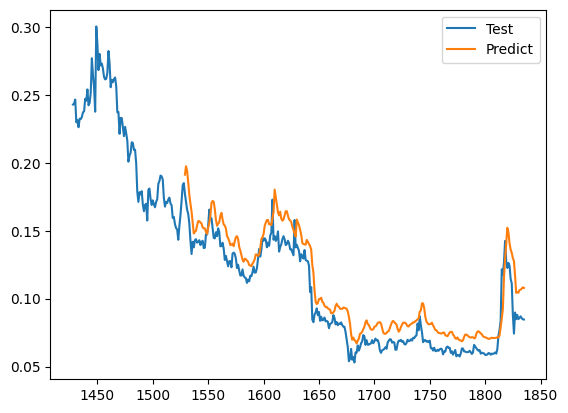

In [202]:
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))

test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))

plt.legend(['Test','Predict'])
plt.show()

In [175]:
print(val_data.shape)
print(y_pred_val.shape)

(204, 1)
(103, 1)


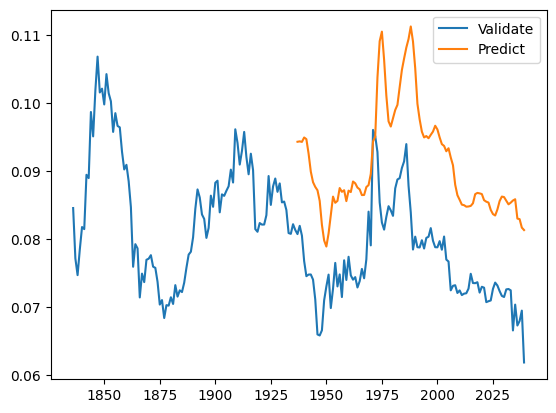

In [176]:
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))

val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)

plt.legend(['Validate','Predict'])
plt.show()

In [177]:
valid_mae = np.mean(np.abs(y_pred_val - yval))
test_mae = np.mean(np.abs(y_pred - ytest))

print('Validation MAE:', valid_mae)
print('Testing MAE:', test_mae)
print('-------------------')

valid_mse = np.mean((y_pred_val - yval)**2)
test_mse = np.mean((y_pred - ytest)**2)

print('Validation MSE:', valid_mse)
print('Testing MSE:', test_mse)
print('-------------------')

valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))

print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)
print('-------------------')

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

valid_mape = mean_absolute_percentage_error(y_pred_val, yval)
test_mape = mean_absolute_percentage_error(y_pred, ytest)
print('Validation MAPE:', valid_mape)
print('Testing MAPE:', test_mape)

Validation MAE: 0.02027666825729178
Testing MAE: 0.055509510493033994
-------------------
Validation MSE: 0.0005404016625439502
Testing MSE: 0.0048171758054094205
-------------------
Validation RMSE: 0.023246540872653508
Testing RMSE: 0.06940587731171922
-------------------
Validation MAPE: 22.980374571783543
Testing MAPE: 58.024539911292


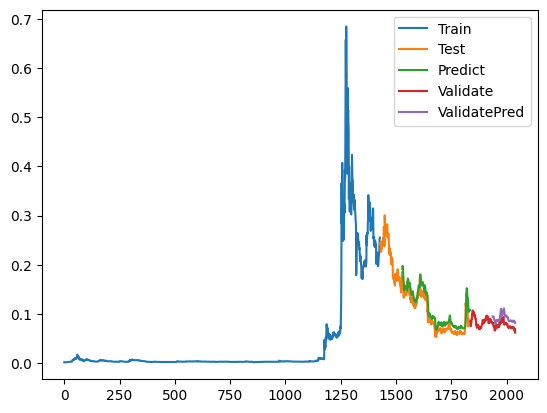

In [178]:
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))

val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)

plt.legend(['Train','Test','Predict','Validate','ValidatePred'])
plt.show()

## 5:3:2

In [179]:
train_size1 = int(0.5 * len(df1))
test_size1 = int(0.3 * len(df1))
val_size1 = len(df1) - train_size1 - test_size1

train_data1 = df1[:train_size1]
test_data1 = df1[train_size1:train_size1 + test_size1]
val_data1 = df1[train_size1 + test_size1:]

In [180]:
time_step = 100
X_train1, y_train1 = create_dataset(train_data1, time_step)
X_val1, yval1 = create_dataset(val_data1, time_step)
X_test1, ytest1 = create_dataset(test_data1, time_step)

In [181]:
X_train1 = X_train1.reshape(X_train1.shape[0],X_train1.shape[1], 1)
X_test1 = X_test1.reshape(X_test1.shape[0],X_test1.shape[1], 1)
X_val1 = X_val1.reshape(X_val1.shape[0],X_val1.shape[1], 1)

In [182]:
# define model
model1 = Sequential()
model1.add(LSTM(100, activation='relu', input_shape=(100,1)))
model1.add(Dense(1))
model1.compile(optimizer='adam', loss='mean_squared_error')

In [183]:
model1.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_9 (LSTM)               (None, 100)               40800     
                                                                 
 dense_9 (Dense)             (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [184]:
model1.fit(X_train1,y_train1,validation_data=(X_test1,ytest1),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
15/15 [==============================] - 5s 189ms/step - loss: 2.7298e-06 - val_loss: 0.0821
Epoch 2/100
15/15 [==============================] - 3s 172ms/step - loss: 1.5594e-06 - val_loss: 0.0778
Epoch 3/100
15/15 [==============================] - 2s 152ms/step - loss: 1.3388e-06 - val_loss: 0.0745
Epoch 4/100
15/15 [==============================] - 2s 153ms/step - loss: 1.2044e-06 - val_loss: 0.0710
Epoch 5/100
15/15 [==============================] - 4s 282ms/step - loss: 1.1138e-06 - val_loss: 0.0679
Epoch 6/100
15/15 [==============================] - 3s 199ms/step - loss: 1.0360e-06 - val_loss: 0.0641
Epoch 7/100
15/15 [==============================] - 3s 171ms/step - loss: 7.5443e-07 - val_loss: 0.0601
Epoch 8/100
15/15 [==============================] - 3s 171ms/step - loss: 7.0819e-07 - val_loss: 0.0563
Epoch 9/100
15/15 [==============================] - 3s 170ms/step - loss: 6.7095e-07 - val_loss: 0.0529
Epoch 10/100
15/15 [==============================] - 4

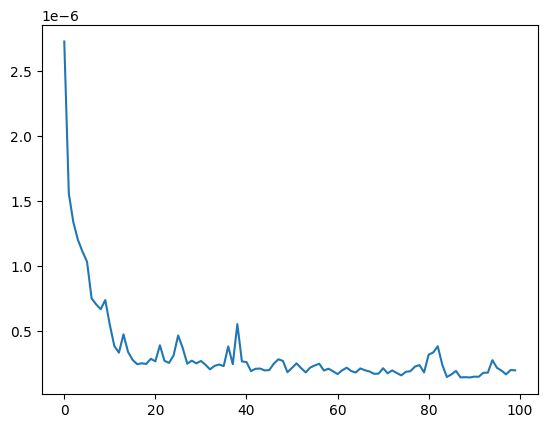

In [185]:
loss_per_epoch = model1.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [186]:
train_predict1 = model.predict(X_train1)
y_pred1 = model.predict(X_test1)
y_pred_val1 = model.predict(X_val1)

10/10 [==============================] - 0s 26ms/step


In [187]:
train_predict1 = scaler.inverse_transform(train_predict1)
y_pred1 = scaler.inverse_transform(y_pred1)
y_pred_val1 = scaler.inverse_transform(y_pred_val1)

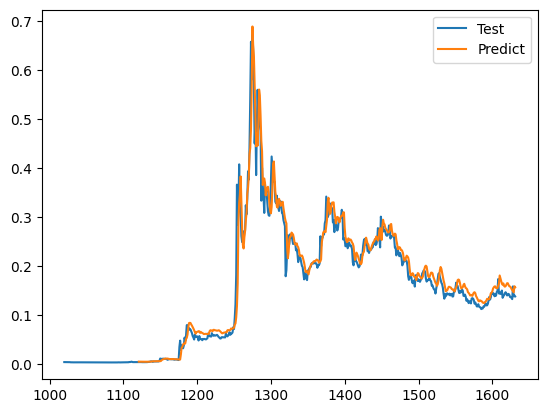

In [188]:
test_data_index1 = pd.RangeIndex(start=train_size1, stop=train_size1+test_size1, step=1)
plt.plot(test_data_index1,scaler.inverse_transform(test_data1))

test_data_index1 = pd.RangeIndex(start=train_size1+101, stop=train_size1+test_size1, step=1)
plt.plot(test_data_index1,(y_pred1))

plt.legend(['Test','Predict'])
plt.show()

In [189]:
print(val_data1.shape)
print(y_pred_val1.shape)

(408, 1)
(307, 1)


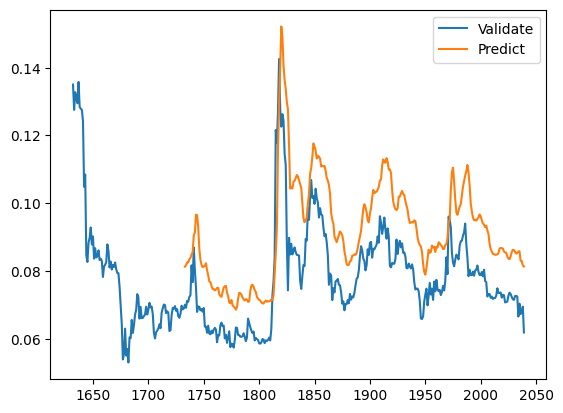

In [190]:
val_data_index1 = pd.RangeIndex(start=train_size1+test_size1, stop=train_size1+test_size1+val_size1, step=1)
plt.plot(val_data_index1,scaler.inverse_transform(val_data1))

val_data_index1 = pd.RangeIndex(start=train_size1+test_size1+101, stop=train_size1+test_size1+val_size1, step=1)
plt.plot(val_data_index1,y_pred_val1)

plt.legend(['Validate','Predict'])
plt.show()

In [191]:
valid_mae1 = np.mean(np.abs(y_pred_val1 - yval1))
test_mae1 = np.mean(np.abs(y_pred1 - ytest1))

print('Validation MAE:', valid_mae1)
print('Testing MAE:', test_mae1)
print('-------------------')

valid_mse1 = np.mean((y_pred_val1 - yval1)**2)
test_mse1 = np.mean((y_pred1 - ytest1)**2)

print('Validation MSE:', valid_mse1)
print('Testing MSE:', test_mse1)
print('-------------------')

valid_rmse1 = np.sqrt(np.mean((y_pred_val1 - yval1)**2))
test_rmse1 = np.sqrt(np.mean((y_pred1 - ytest1)**2))

print('Validation RMSE:', valid_rmse1)
print('Testing RMSE:', test_rmse1)
print('-------------------')

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

valid_mape1 = mean_absolute_percentage_error(y_pred_val1, yval1)
test_mape1 = mean_absolute_percentage_error(y_pred1, ytest1)
print('Validation MAPE:', valid_mape1)
print('Testing MAPE:', test_mape1)

Validation MAE: 0.0254162870499461
Testing MAE: 0.17307081908493588
-------------------
Validation MSE: 0.0010470997065419897
Testing MSE: 0.0494078922693192
-------------------
Validation RMSE: 0.03235892004597789
Testing RMSE: 0.22227886149906204
-------------------
Validation MAPE: 29.643091992268527
Testing MAPE: 586.7710181779545


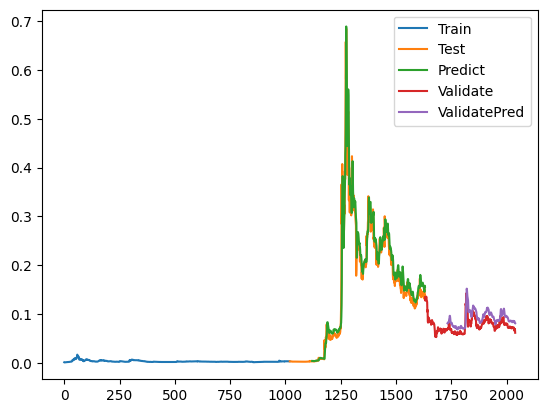

In [192]:
train_data_index1 = pd.RangeIndex(start=0, stop=train_size1, step=1)
plt.plot(scaler.inverse_transform(train_data1))

test_data_index1 = pd.RangeIndex(start=train_size1, stop=train_size1+test_size1, step=1)
plt.plot(test_data_index1,scaler.inverse_transform(test_data1))
test_data_index1 = pd.RangeIndex(start=train_size1+101, stop=train_size1+test_size1, step=1)
plt.plot(test_data_index1,(y_pred1))

val_data_index1 = pd.RangeIndex(start=train_size1+test_size1, stop=train_size1+test_size1+val_size1, step=1)
plt.plot(val_data_index1,scaler.inverse_transform(val_data1))
val_data_index1 = pd.RangeIndex(start=train_size1+test_size1+101, stop=train_size1+test_size1+val_size1, step=1)
plt.plot(val_data_index1,y_pred_val1)

plt.legend(['Train','Test','Predict','Validate','ValidatePred'])
plt.show()

# ETH-USD

In [203]:
df = pd.read_csv('/content/drive/MyDrive/BA/Dataset/ETH-USD.csv',usecols=['Date','Close'],index_col='Date',parse_dates=True)

In [204]:
df.head()

,Close
Date,
2017-11-09,320.884003
2017-11-10,299.252991
2017-11-11,314.681000
2017-11-12,307.907990
2017-11-13,316.716003


<Axes: xlabel='Date'>

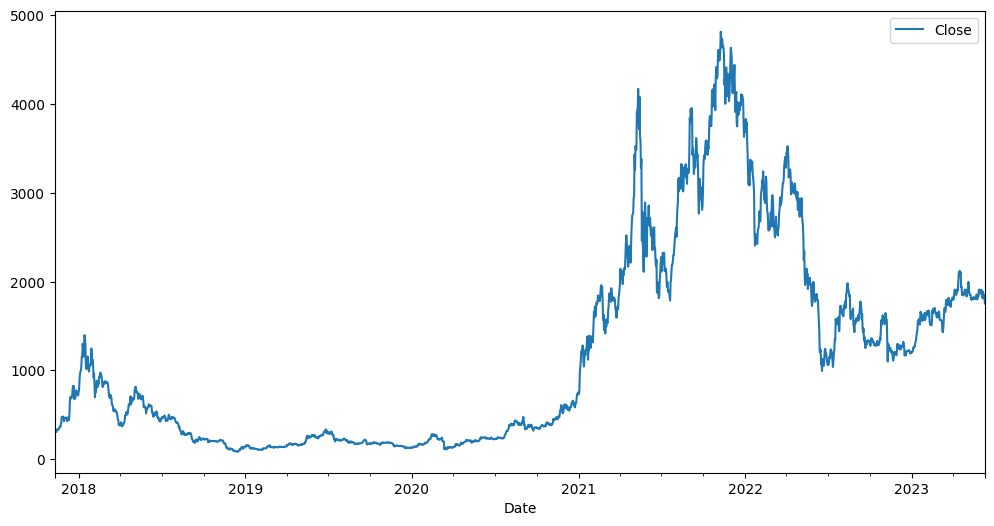

In [205]:
df.plot(figsize=(12,6))

In [206]:
df1 = df.reset_index()['Close']

In [207]:
len(df1)

2040

## 7:2:1

In [208]:
scaler = MinMaxScaler(feature_range=(0,1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1,1))

In [209]:
train_size = int(0.7 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size + test_size]
val_data = df1[train_size + test_size:]

In [210]:
import numpy
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [211]:
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [212]:
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1], 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1], 1)

In [213]:
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(100,1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [214]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 100)               40800     
                                                                 
 dense_10 (Dense)            (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [215]:
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
21/21 [==============================] - 6s 159ms/step - loss: 0.0272 - val_loss: 0.0050
Epoch 2/100
21/21 [==============================] - 5s 240ms/step - loss: 0.0036 - val_loss: 0.0038
Epoch 3/100
21/21 [==============================] - 3s 157ms/step - loss: 0.0016 - val_loss: 0.0023
Epoch 4/100
21/21 [==============================] - 3s 149ms/step - loss: 0.0012 - val_loss: 0.0019
Epoch 5/100
21/21 [==============================] - 3s 149ms/step - loss: 0.0010 - val_loss: 0.0017
Epoch 6/100
21/21 [==============================] - 5s 225ms/step - loss: 9.4259e-04 - val_loss: 0.0016
Epoch 7/100
21/21 [==============================] - 4s 173ms/step - loss: 9.0938e-04 - val_loss: 0.0017
Epoch 8/100
21/21 [==============================] - 3s 143ms/step - loss: 8.6341e-04 - val_loss: 0.0023
Epoch 9/100
21/21 [==============================] - 3s 143ms/step - loss: 9.3835e-04 - val_loss: 0.0015
Epoch 10/100
21/21 [==============================] - 4s 207ms/step - loss:

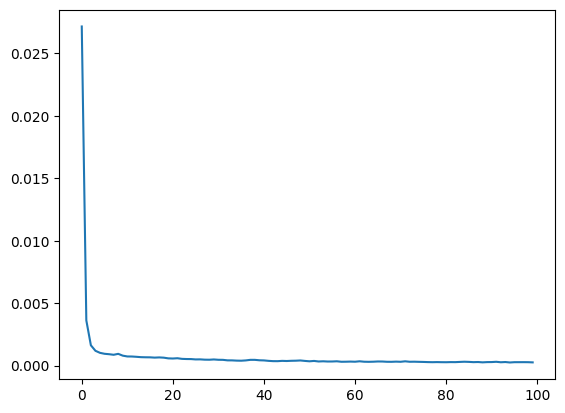

In [216]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [217]:
train_predict = model.predict(X_train)
y_pred = model.predict(X_test)
y_pred_val = model.predict(X_val)

4/4 [==============================] - 0s 25ms/step


In [218]:
train_predict = scaler.inverse_transform(train_predict)
y_pred = scaler.inverse_transform(y_pred)
y_pred_val = scaler.inverse_transform(y_pred_val)

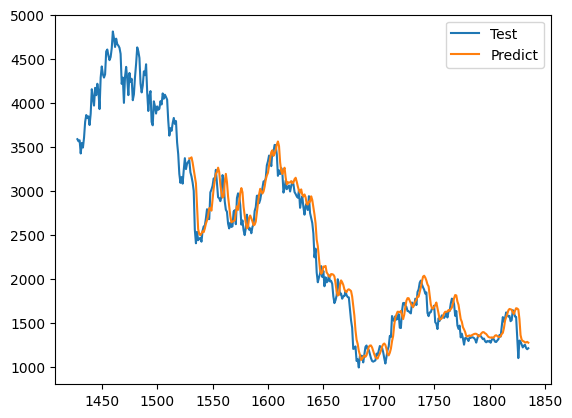

In [219]:
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))

test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))

plt.legend(['Test','Predict'])
plt.show()

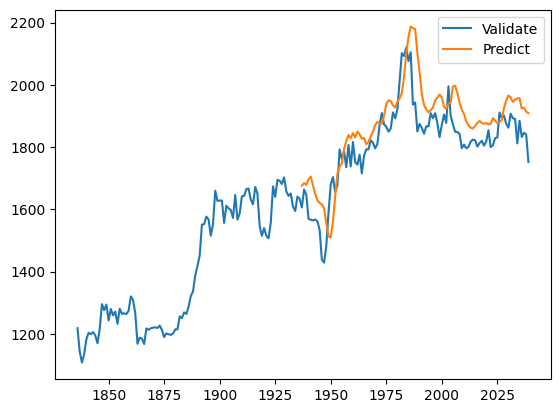

In [220]:
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))

val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)

plt.legend(['Validate','Predict'])
plt.show()

In [221]:
print(val_data.shape)
print(y_pred_val.shape)

(204, 1)
(103, 1)


In [222]:
valid_mae = np.mean(np.abs(y_pred_val - yval))
test_mae = np.mean(np.abs(y_pred - ytest))

print('Validation MAE:', valid_mae)
print('Testing MAE:', test_mae)
print('-------------------')

valid_mse = np.mean((y_pred_val - yval)**2)
test_mse = np.mean((y_pred - ytest)**2)

print('Validation MSE:', valid_mse)
print('Testing MSE:', test_mse)
print('-------------------')

valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))

print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)
print('-------------------')

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

valid_mape = mean_absolute_percentage_error(y_pred_val, yval)
test_mape = mean_absolute_percentage_error(y_pred, ytest)
print('Validation MAPE:', valid_mape)
print('Testing MAPE:', test_mape)

Validation MAE: 1872.0513048450428
Testing MAE: 2096.8624279801425
-------------------
Validation MSE: 3522713.4538533078
Testing MSE: 4935610.724216426
-------------------
Validation RMSE: 1876.8893025038285
Testing RMSE: 2221.6234433891864
-------------------
Validation MAPE: 99.9803730472269
Testing MAPE: 99.97780847299576


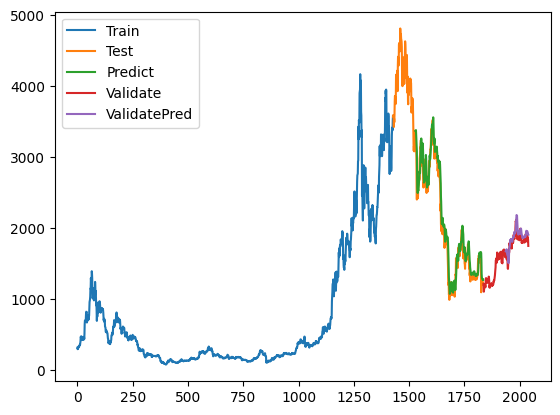

In [223]:
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))

val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)

plt.legend(['Train','Test','Predict','Validate','ValidatePred'])
plt.show()

## 5:3:2

In [224]:
train_size1 = int(0.5 * len(df1))
test_size1 = int(0.3 * len(df1))
val_size1 = len(df1) - train_size1 - test_size1

train_data1 = df1[:train_size1]
test_data1 = df1[train_size1:train_size1 + test_size1]
val_data1 = df1[train_size1 + test_size1:]

In [225]:
time_step = 100
X_train1, y_train1 = create_dataset(train_data1, time_step)
X_val1, yval1 = create_dataset(val_data1, time_step)
X_test1, ytest1 = create_dataset(test_data1, time_step)

In [226]:
X_train1 = X_train1.reshape(X_train1.shape[0],X_train1.shape[1], 1)
X_test1 = X_test1.reshape(X_test1.shape[0],X_test1.shape[1], 1)
X_val1 = X_val1.reshape(X_val1.shape[0],X_val1.shape[1], 1)

In [227]:
# define model
model1 = Sequential()
model1.add(LSTM(100, activation='relu', input_shape=(100,1)))
model1.add(Dense(1))
model1.compile(optimizer='adam', loss='mean_squared_error')

In [228]:
model1.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_11 (LSTM)              (None, 100)               40800     
                                                                 
 dense_11 (Dense)            (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [229]:
model1.fit(X_train1,y_train1,validation_data=(X_test1,ytest1),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
15/15 [==============================] - 4s 182ms/step - loss: 8.4205e-04 - val_loss: 0.0910
Epoch 2/100
15/15 [==============================] - 4s 277ms/step - loss: 2.1294e-04 - val_loss: 0.0060
Epoch 3/100
15/15 [==============================] - 3s 179ms/step - loss: 6.9608e-05 - val_loss: 0.0050
Epoch 4/100
15/15 [==============================] - 2s 169ms/step - loss: 5.0410e-05 - val_loss: 0.0047
Epoch 5/100
15/15 [==============================] - 2s 167ms/step - loss: 4.7663e-05 - val_loss: 0.0045
Epoch 6/100
15/15 [==============================] - 2s 169ms/step - loss: 4.5018e-05 - val_loss: 0.0045
Epoch 7/100
15/15 [==============================] - 4s 311ms/step - loss: 4.2359e-05 - val_loss: 0.0044
Epoch 8/100
15/15 [==============================] - 2s 158ms/step - loss: 4.4878e-05 - val_loss: 0.0040
Epoch 9/100
15/15 [==============================] - 3s 174ms/step - loss: 4.0525e-05 - val_loss: 0.0046
Epoch 10/100
15/15 [==============================] - 2

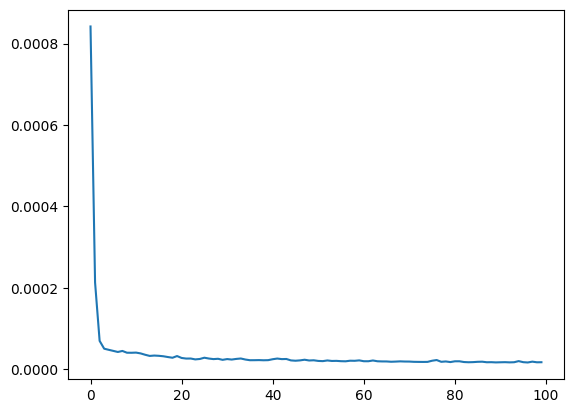

In [230]:
loss_per_epoch = model1.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [231]:
train_predict1 = model.predict(X_train1)
y_pred1 = model.predict(X_test1)
y_pred_val1 = model.predict(X_val1)

10/10 [==============================] - 0s 27ms/step


In [232]:
train_predict1 = scaler.inverse_transform(train_predict1)
y_pred1 = scaler.inverse_transform(y_pred1)
y_pred_val1 = scaler.inverse_transform(y_pred_val1)

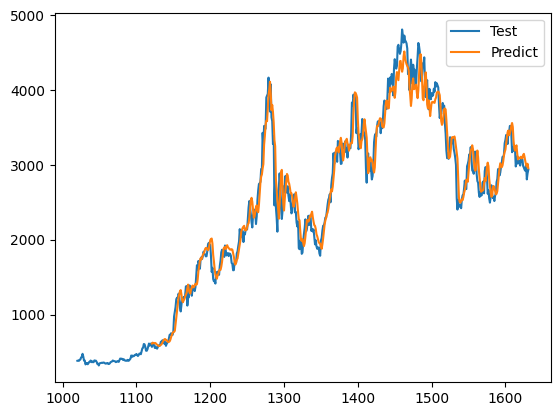

In [233]:
test_data_index1 = pd.RangeIndex(start=train_size1, stop=train_size1+test_size1, step=1)
plt.plot(test_data_index1,scaler.inverse_transform(test_data1))

test_data_index1 = pd.RangeIndex(start=train_size1+101, stop=train_size1+test_size1, step=1)
plt.plot(test_data_index1,(y_pred1))

plt.legend(['Test','Predict'])
plt.show()

In [234]:
print(val_data1.shape)
print(y_pred_val1.shape)

(408, 1)
(307, 1)


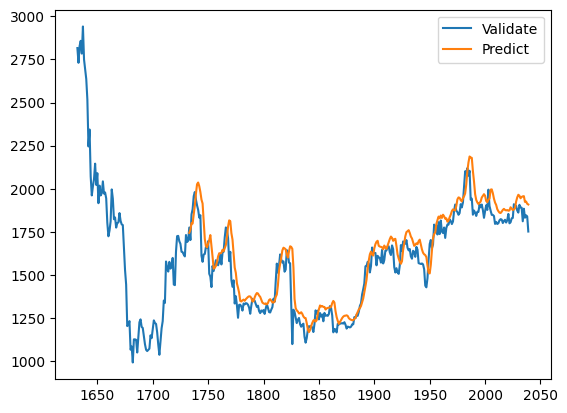

In [235]:
val_data_index1 = pd.RangeIndex(start=train_size1+test_size1, stop=train_size1+test_size1+val_size1, step=1)
plt.plot(val_data_index1,scaler.inverse_transform(val_data1))

val_data_index1 = pd.RangeIndex(start=train_size1+test_size1+101, stop=train_size1+test_size1+val_size1, step=1)
plt.plot(val_data_index1,y_pred_val1)

plt.legend(['Validate','Predict'])
plt.show()

In [236]:
valid_mae1 = np.mean(np.abs(y_pred_val1 - yval1))
test_mae1 = np.mean(np.abs(y_pred1 - ytest1))

print('Validation MAE:', valid_mae1)
print('Testing MAE:', test_mae1)
print('-------------------')

valid_mse1 = np.mean((y_pred_val1 - yval1)**2)
test_mse1 = np.mean((y_pred1 - ytest1)**2)

print('Validation MSE:', valid_mse1)
print('Testing MSE:', test_mse1)
print('-------------------')

valid_rmse1 = np.sqrt(np.mean((y_pred_val1 - yval1)**2))
test_rmse1 = np.sqrt(np.mean((y_pred1 - ytest1)**2))

print('Validation RMSE:', valid_rmse1)
print('Testing RMSE:', test_rmse1)
print('-------------------')

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

valid_mape1 = mean_absolute_percentage_error(y_pred_val1, yval1)
test_mape1 = mean_absolute_percentage_error(y_pred1, ytest1)
print('Validation MAPE:', valid_mape1)
print('Testing MAPE:', test_mape1)

Validation MAE: 1622.8796647104505
Testing MAE: 2710.705713934852
-------------------
Validation MSE: 2699950.510326716
Testing MSE: 8290691.525385479
-------------------
Validation RMSE: 1643.1526132184788
Testing RMSE: 2879.356095620248
-------------------
Validation MAPE: 99.98015521728189
Testing MAPE: 99.97431443224148


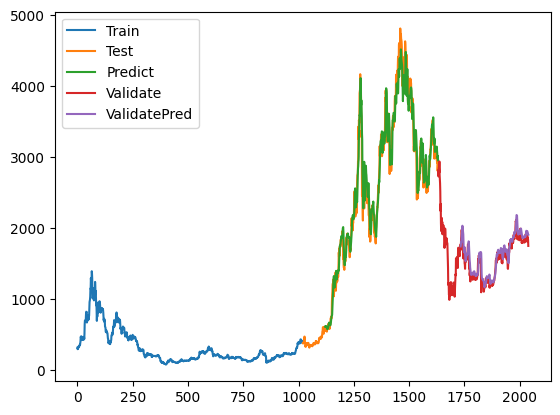

In [237]:
train_data_index1 = pd.RangeIndex(start=0, stop=train_size1, step=1)
plt.plot(scaler.inverse_transform(train_data1))

test_data_index1 = pd.RangeIndex(start=train_size1, stop=train_size1+test_size1, step=1)
plt.plot(test_data_index1,scaler.inverse_transform(test_data1))
test_data_index1 = pd.RangeIndex(start=train_size1+101, stop=train_size1+test_size1, step=1)
plt.plot(test_data_index1,(y_pred1))

val_data_index1 = pd.RangeIndex(start=train_size1+test_size1, stop=train_size1+test_size1+val_size1, step=1)
plt.plot(val_data_index1,scaler.inverse_transform(val_data1))
val_data_index1 = pd.RangeIndex(start=train_size1+test_size1+101, stop=train_size1+test_size1+val_size1, step=1)
plt.plot(val_data_index1,y_pred_val1)

plt.legend(['Train','Test','Predict','Validate','ValidatePred'])
plt.show()